# 1. Noise-free data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 1.1

In [2]:
def simulate_sir_simple(lam, mu, I_0, T):
    """
    simulates the epidemy using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0
    
    # Lists to store observations and ODE variables
    X = np.zeros((T, 2))
    C = np.zeros((T, 3))
    
    for day in range(T):
        
        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X[day] = [dS,dR]
        C[day] = [S, I, R]

    
    return X, C


## 1.2

In [3]:
def plot_sir_simulation(C, title='SIR Model Simulation'):
    """
    Plots the SIR simulation results.

    C: Array containing the S, I, R values at each timestep
    T: Total number of days in the simulation
    """
    days = range(len(C))

    # Extract S, I, R values
    S, I, R = C[:,0], C[:,1], C[:,2]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(days, S, label='Susceptible')
    plt.plot(days, I, label='Infected')
    plt.plot(days, R, label='Recovered')

    plt.xlabel('Days')
    plt.ylabel('Population Proportion')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

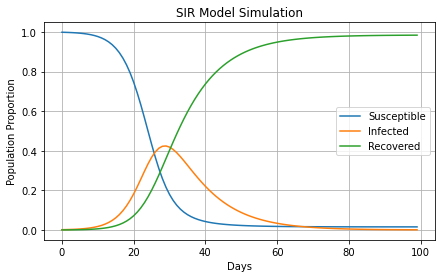

In [4]:
lambda_val = 0.4 
mu_val = 0.1     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

After some trial and error we found values $\lambda$ = 0.25, $\mu$ = 0.1, and $I_0$ = 0.001 that exhibit interesting and diverse dynamics. Now we look at the ranges of each value where we still see interesting dynamics

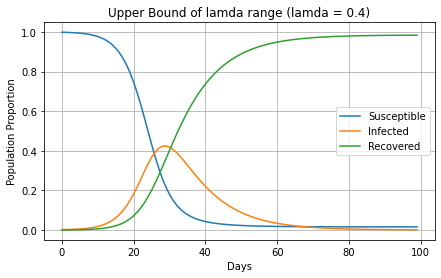

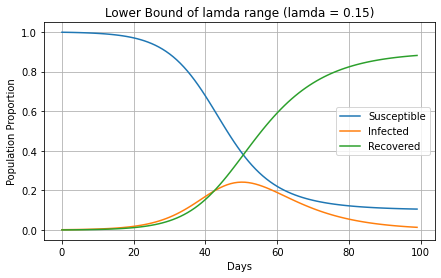

In [5]:
lambda_val_1 = 0.40
lambda_val_2 = 0.25

X_1, C_1 = simulate_sir_simple(lambda_val_1, mu_val, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val_2, mu_val, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of lamda range (lamda = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of lamda range (lamda = 0.15)")

So lambda should be in the range between $\lambda = [0.25, 0.4]$. Lets do the same with $\mu$ and $I_0$

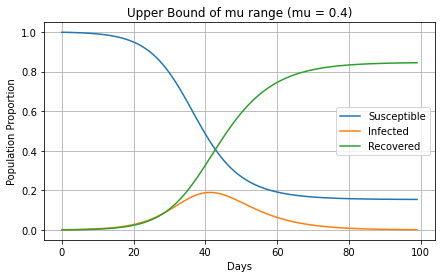

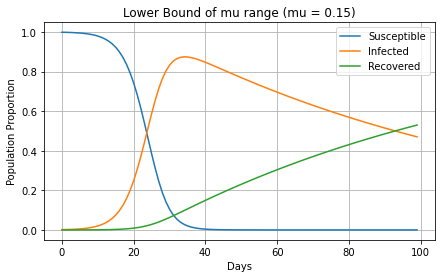

In [6]:
mu_val_1 = 0.15
mu_val_2 = 0.01
lambda_val = 0.325

X_1, C_1 = simulate_sir_simple(lambda_val, mu_val_1, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val_2, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of mu range (mu = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of mu range (mu = 0.15)")

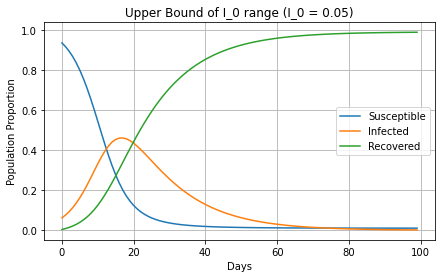

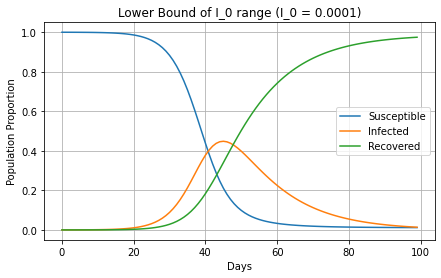

In [7]:
mu_val = 0.075
initial_infected_1 = 0.05  
initial_infected_2 = 0.0001  


X_1, C_1 = simulate_sir_simple(lambda_val, mu_val, initial_infected_1, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val, initial_infected_2, num_days)

plot_sir_simulation(C_1, title="Upper Bound of I_0 range (I_0 = 0.05)")
plot_sir_simulation(C_2, title="Lower Bound of I_0 range (I_0 = 0.0001)")

From our test we get suitable range of:   
$\lambda = [0.25, 0.4]$
$\mu = [0.01, 0.15]$
$I_0 = [0.0001, 0.05]$

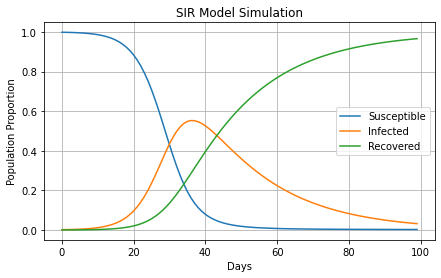

In [8]:
lambda_val = 0.3 
mu_val = 0.05     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

## 1.3

First, we define a dataset for training:

In [9]:
class SIRDataset(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)  
        mu_prior = np.random.uniform(0.01, 0.15, size=size)  
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)
        
        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            X, _ = simulate_sir_simple(lam, mu, I_0, T)
            self.data.append(X)
            self.targets.append([lam, mu, I_0])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

Next, we define a network architecture and train it on our datasets

In [10]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, 3))  # Output layer

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x
    
def train_network(net, train_loader, validation_loader, optimizer, criterion, epochs=5):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        # Train:
        train_loss = 0
        net.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
        
        # Validate: 
        net.eval()
        validation_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                outputs = net(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        validation_loss = validation_loss/len(validation_loader)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(f"[{epoch}/{epochs}] train loss: {train_loss}, validation loss: {validation_loss}")

    return train_losses, validation_losses

def evaluate_network(net, test_loader, criterion):
    with torch.no_grad():
        test_loss = 0
        for data, targets in test_loader:
            outputs = net(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        test_loss = test_loss/len(test_loader)
    return test_loss

def plot_losses(validation_loss, train_loss = None, label="validation"):
    if train_loss is not None:
        plt.plot(train_loss, label="training")
    plt.plot(validation_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

In [11]:
train_dataset = SIRDataset(size=1000, T=100)
validation_dataset = SIRDataset(size=200, T=100) 
test_dataset = SIRDataset(size=200, T=100) 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

[0/10] train loss: 0.020826925814617425, validation loss: 0.005676018406770059
[1/10] train loss: 0.0021208489251876017, validation loss: 0.00127230110644762
[2/10] train loss: 0.0011026550710084848, validation loss: 0.0010725965008272656
[3/10] train loss: 0.0009592687893018592, validation loss: 0.0009910993311288102
[4/10] train loss: 0.0008620897042419529, validation loss: 0.0008767191902734339
[5/10] train loss: 0.0007717734570178436, validation loss: 0.0008373032490323697
[6/10] train loss: 0.0007037994510028511, validation loss: 0.0007320400161136474
[7/10] train loss: 0.0006401903747246251, validation loss: 0.0006912547645957343
[8/10] train loss: 0.0006004420692988788, validation loss: 0.0006214174874393004
[9/10] train loss: 0.0005526173886210017, validation loss: 0.000574675459314936


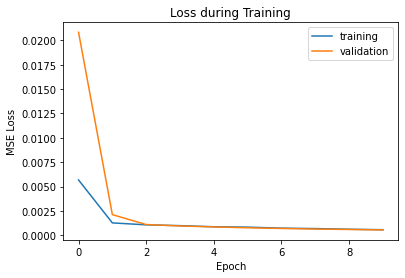

In [12]:
net = SIRNet(input_size=100*2, hidden_size=50, n_hidden_layers=0)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss,validation_loss = train_network(net, train_loader,validation_loader, optimizer, criterion, 10)
plot_losses(train_loss, validation_loss)
plt.title("Loss during Training")
plt.legend()
plt.show()


[0/10] train loss: 0.04625900578685105, validation loss: 0.03706961604101317
[1/10] train loss: 0.02661492768675089, validation loss: 0.016990635277969495
[2/10] train loss: 0.00962199158675503, validation loss: 0.004571408698601382
[3/10] train loss: 0.002428307241643779, validation loss: 0.0016476280954001205
[4/10] train loss: 0.0012923398935527075, validation loss: 0.0013307742109256132
[5/10] train loss: 0.0012259589802852133, validation loss: 0.0014178298546799592
[6/10] train loss: 0.0012136780460423324, validation loss: 0.001323668668711824
[7/10] train loss: 0.001191772233141819, validation loss: 0.001279869515980993
[8/10] train loss: 0.0011634720249276143, validation loss: 0.0012193253247200378
[9/10] train loss: 0.0011535800622368697, validation loss: 0.001186697486056281
[0/10] train loss: 0.007643578501301818, validation loss: 0.003230482805520296
[1/10] train loss: 0.0018308802245883271, validation loss: 0.0013921192481315561
[2/10] train loss: 0.0012484749640861992, val

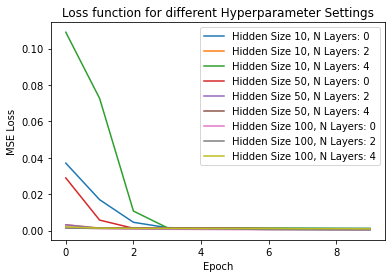

In [13]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [10, 50, 100]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size, n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _,validation_loss = train_network(net, train_loader,validation_loader, optimizer, criterion, 10)
        


[0/20] train loss: 0.030818007158813998, validation loss: 0.009922938820506846
[1/20] train loss: 0.003325112393213203, validation loss: 0.0013560495405857051
[2/20] train loss: 0.0011138562458654633, validation loss: 0.0010951577236742846
[3/20] train loss: 0.0009477317598793888, validation loss: 0.0009673314468402948
[4/20] train loss: 0.0008624530073575443, validation loss: 0.0009331326582469046
[5/20] train loss: 0.0007820790560799651, validation loss: 0.0008681729003520948
[6/20] train loss: 0.0006987956348893931, validation loss: 0.0007299982909379261
[7/20] train loss: 0.0006200467150847544, validation loss: 0.000641110581844779
[8/20] train loss: 0.0005784489112556912, validation loss: 0.0006914339818259967
[9/20] train loss: 0.000531035877429531, validation loss: 0.0005556747616667833
[10/20] train loss: 0.0005050611439401109, validation loss: 0.000601414279247235
[11/20] train loss: 0.0004938572474202374, validation loss: 0.0006020336046016642
[12/20] train loss: 0.0004870439

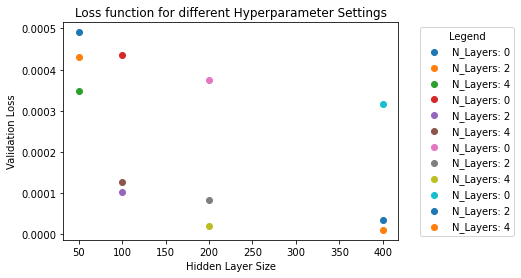

In [17]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [50, 100, 200, 400]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size, n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _,_ = train_network(net, train_loader,validation_loader, optimizer, criterion, 20)
        test_loss = evaluate_network(net, test_loader, criterion)

        plt.scatter(hidden_size, test_loss, label=f'N_Layers: {n_layer}')
        

plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')
# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('Loss on Test Dataset for different Hyperparameter Settings')
plt.show()

We see the larger the network the better the performance in our case and we get the best results for 4 layers and a hidden size of 400. We can also observe that having more layers in these tests have a stronger influence on the outcome than the hidden size. For now we stick with our found network parameter since they perform good enough for our case.  

Lets now look into variable dataset sizes

[0/20] train loss: 0.007619598676683381, validation loss: 0.0024633868264832665
[1/20] train loss: 0.001439888776076259, validation loss: 0.0013626932632178068
[2/20] train loss: 0.001221509497554507, validation loss: 0.001397245397259082
[3/20] train loss: 0.0011942078417632729, validation loss: 0.0013360703763152873
[4/20] train loss: 0.0011122518189949915, validation loss: 0.0012216098007879087
[5/20] train loss: 0.0009854048548731953, validation loss: 0.0010245006498215453
[6/20] train loss: 0.0009021387959364802, validation loss: 0.0010466076866058366
[7/20] train loss: 0.0008538243891962338, validation loss: 0.000968174626385527
[8/20] train loss: 0.0008217369795602281, validation loss: 0.0009523274909172739
[9/20] train loss: 0.0007353885303018615, validation loss: 0.0007876731106080115
[10/20] train loss: 0.0006026198861945886, validation loss: 0.0005844981392978557
[11/20] train loss: 0.0004042156097057159, validation loss: 0.0003956337958308203
[12/20] train loss: 0.000323848

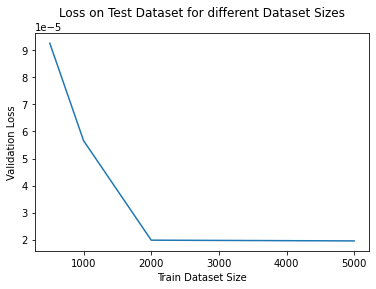

In [25]:
trainset_sizes = [500, 1000, 2000, 5000]
test_losses = []
for train_size in trainset_sizes:
    train_dataset = SIRDataset(size=train_size, T=100)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    net = SIRNet(input_size=100*2, hidden_size=400, n_hidden_layers=4)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    _,_ = train_network(net, train_loader,validation_loader, optimizer, criterion, 20)
    test_loss = evaluate_network(net, test_loader, criterion)
    test_losses.append(test_loss)

        
plt.plot(trainset_sizes, test_losses)

plt.xlabel('Train Dataset Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')

plt.title('Loss on Test Dataset for different Dataset Sizes')
plt.show()

We can't see any substantial improvements after a dataset size of 2000

## 1.4

In [ ]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
import torch.nn.functional as F

import torch.nn.functional as F
from torch.nn.functional import one_hot

class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        """
        Initialize a ConditionalCouplingLayer.

        Args:
        - input_size (int): Total size of the input data.
        - hidden_size (int): Size of the hidden layers in the neural networks.
        - condition_size (int): Size of the condition vector (e.g., one-hot encoded label size).
        """
        super(ConditionalCouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2 + condition_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x, condition):
        """
        Forward pass through the ConditionalCouplingLayer.

        Args:
        - x (torch.Tensor): Input data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - y (torch.Tensor): Transformed data.
        - scaling_before_exp (torch.Tensor): Scaling coefficients before the exponential operation.
        """
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)

        # Concatenate conditions to the first half
        x_a_concat = torch.cat([x_a, condition], dim=1)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a_concat))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = torch.tanh(self.fc4(h))
        scaling = torch.exp(scaling_before_exp)

        # Apply the affine transformation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([x_a, y_b], dim=1)
        return y, scaling_before_exp

    def backward(self, y, condition):
        """
        Backward pass through the ConditionalCouplingLayer.

        Args:
        - y (torch.Tensor): Transformed data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - x (torch.Tensor): Reconstructed original input.
        """
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Concatenate conditions to the first half
        y_a_concat = torch.cat([y_a, condition], dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a_concat))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Reverse the operations to reconstruct the original input
        x_a = y_a
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

In [ ]:
### conditional real NVP class
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size, blocks):
        """
        Initialize a ConditionalRealNVP model.

        Args:
        - input_size (int): Total size of the input data.
        - hidden_size (int): Size of the hidden layers in the neural networks.
        - condition_size (int): Size of the condition vector (e.g., one-hot encoded label size).
        - blocks (int): Number of coupling layers in the model.
        """
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, hidden_size, condition_size) for _ in range(blocks)
        ])

        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

    def _get_orthonormal_matrix(self, size):
        """
        Generate a random orthonormal matrix.

        Args:
        - size (int): Size of the matrix.

        Returns:
        - q (torch.Tensor): Orthonormal matrix.
        """
        w = torch.randn(size, size)
        q, _ = torch.linalg.qr(w, 'reduced')
        return q

    def forward_realnvp(self, x, condition):
        """
        Forward pass through the ConditionalRealNVP model.

        Args:
        - x (torch.Tensor): Input data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - x (torch.Tensor): Transformed data.
        """
        scaling_before_exp_list = []
        for i in range(self.blocks):
            #print("x is:"); print(x)
            #print("shape of x is:"); print(x.shape)
            x = torch.matmul(x, self.orthonormal_matrices[i])
            x, scaling_before_exp = self.coupling_layers[i].forward(x, condition)
            scaling_before_exp_list.append(scaling_before_exp)

        self.scaling_before_exp_list = scaling_before_exp_list
        return x

    def decode(self, z, condition):
        """
        Reverse transformations to decode data.

        Args:
        - z (torch.Tensor): Transformed data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - z (torch.Tensor): Reconstructed original data.
        """
        for i in reversed(range(self.blocks)):
            z = self.coupling_layers[i].backward(z, condition)
            z = torch.matmul(z, self.orthonormal_matrices[i].t())
        return z

    def sample(self, num_samples=1000, conditions=None):
        """
        Generate synthetic samples.

        Args:
        - num_samples (int): Number of synthetic samples to generate.
        - conditions (torch.Tensor): Conditions for generating synthetic samples.

        Returns:
        - synthetic_samples (torch.Tensor): Synthetic samples.
        """
        with torch.no_grad():
            z = torch.randn(num_samples, self.input_size)
            synthetic_samples = self.decode(z, conditions)
        return synthetic_samples

# 2. Noisy data

# 3. Model misspecification detection

# 4. Sensitivity analysis